In [1]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-tensorflow/1.6.0-gnimlf4/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (typ

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_hdf('data/data_X.h5') # load data processed with ML_processor.py

sig_df = df[df['signal']==1]
bkg_df = df[df['signal']==0]

# usually we have less signal than background
nSmall = len(sig_df) if len(sig_df) < len(bkg_df) else len(bkg_df)

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSmall )
tmp_sig_df = sig_df.sample( n = nSmall )

y_sig = np.ones(len(tmp_sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [tmp_sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

print ("The smaller data set contains %s events"%nSmall)

# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.9*y_tmp.shape[0] ), random_state=42 )

#variables = ['met','ht','lead_jet_pt','sublead_jet_pt','lead_jet_eta','sublead_jet_eta','njets','bjets','min_dphi_met_j2','signal']
variables = ['ht','min_dphi_met_j2','signal']
#variables = ['lead_jet_eta','sublead_jet_eta','bjets','signal']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]

The smaller data set contains 25188 events


/cvmfs/cms.cern.ch/slc6_amd64_gcc700/external/py2-scikit-learn/0.19.1/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


No handles with labels found to put in legend.


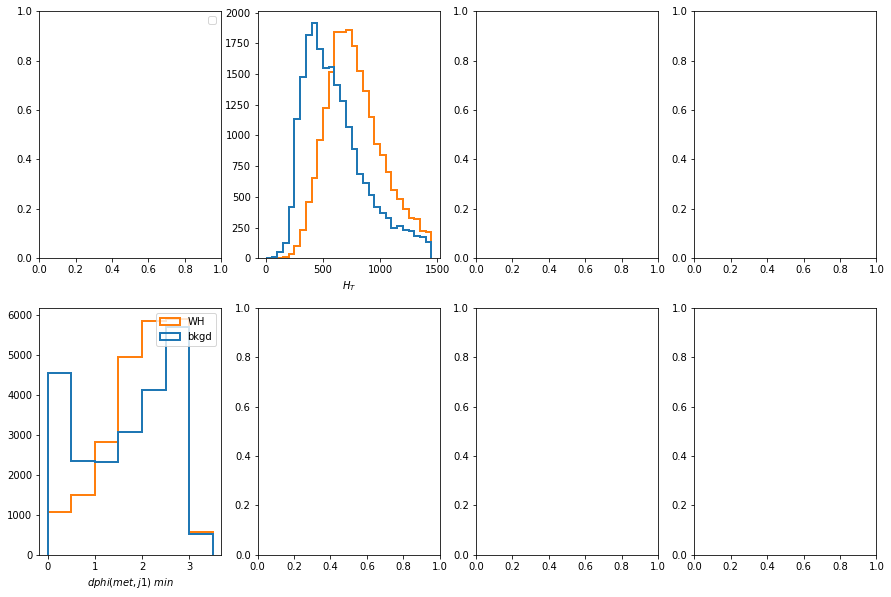

In [4]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(2,4, figsize=(15,10))

phibins = [0.0,0.5,1.0,1.5,2.0,2.5,3.0,3.5]

#hist, bins, ax = axs[0,0].hist( [ X_bkg[['met']].values.flatten(), X_sig[['met']].values.flatten() ], range(0,500,25), histtype='step', linewidth=2, label=['bkgd', 'WH']) 
hist, bins, ax = axs[0,1].hist( [ X_bkg[['ht']].values.flatten(), X_sig[['ht']].values.flatten() ], range(0,1500,50), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[0,2].hist( [ X_bkg[['lead_jet_pt']].values.flatten(), X_sig[['lead_jet_pt']].values.flatten() ], range(0,500,25), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[0,3].hist( [ X_bkg[['sublead_jet_pt']].values.flatten(), X_sig[['sublead_jet_pt']].values.flatten() ], range(0,500,25), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,0].hist( [ X_bkg[['lead_jet_eta']].values.flatten(), X_sig[['lead_jet_eta']].values.flatten() ], range(0,3,1), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,1].hist( [ X_bkg[['sublead_jet_eta']].values.flatten(), X_sig[['sublead_jet_eta']].values.flatten() ], range(0,3,1), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,2].hist( [ X_bkg[['njets']].values.flatten(), X_sig[['njets']].values.flatten() ], range(0,15,1), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,3].hist( [ X_bkg[['bjets']].values.flatten(), X_sig[['bjets']].values.flatten() ], range(0,15,1), histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,0].hist( [ X_bkg[['min_dphi_met_j1']].values.flatten(), X_sig[['min_dphi_met_j1']].values.flatten() ], phibins, histtype='step', linewidth=2, label=['bkgd', 'WH']) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['min_dphi_met_j2']].values.flatten(), X_sig[['min_dphi_met_j2']].values.flatten() ], phibins, histtype='step', linewidth=2, label=['bkgd', 'WH']) 
#hist, bins, ax = axs[1,2].hist( [ X_bkg[['min_dphi_met_j3']].values.flatten(), X_sig[['min_dphi_met_j3']].values.flatten() ], phibins, histtype='step', linewidth=2, label=['bkgd', 'WH']) 
#hist, bins, ax = axs[1,3].hist( [ X_bkg[['min_dphi_met_j4']].values.flatten(), X_sig[['min_dphi_met_j4']].values.flatten() ], phibins, histtype='step', linewidth=2, label=['bkgd', 'WH']) 

#axs[0,0].set_xlabel(r'$E_{T}^{miss}$')
axs[0,1].set_xlabel(r'$H_{T}$')
#axs[0,2].set_xlabel(r'$lead jet pt$')
#axs[0,3].set_xlabel(r'$sublead jet pt$')
#axs[1,0].set_xlabel(r'$lead jet eta$')
#axs[1,1].set_xlabel(r'$sublead jet eta$')
#axs[1,2].set_xlabel(r'$N_{jet}$')
#axs[1,3].set_xlabel(r'$N_{b jet}$')
#axs[1,0].set_xlabel(r'$dphi(met,j0)~{min}$')
axs[1,0].set_xlabel(r'$dphi(met,j1)~{min}$')
#axs[1,2].set_xlabel(r'$dphi(met,j2)~{min}$')
#axs[1,3].set_xlabel(r'$dphi(met,j3)~{min}$')

axs[0,0].legend()
axs[1,0].legend()
#axs[2,0].legend()

plt.savefig('plots/training_vars.pdf')

In [5]:
# Normalize Data - mean to 0, and std to 1 
X_mean, X_std = X_train.mean(), X_train.std()

X_train -= X_mean
X_train /= X_std

X_test -= X_mean
X_test /= X_std

No handles with labels found to put in legend.


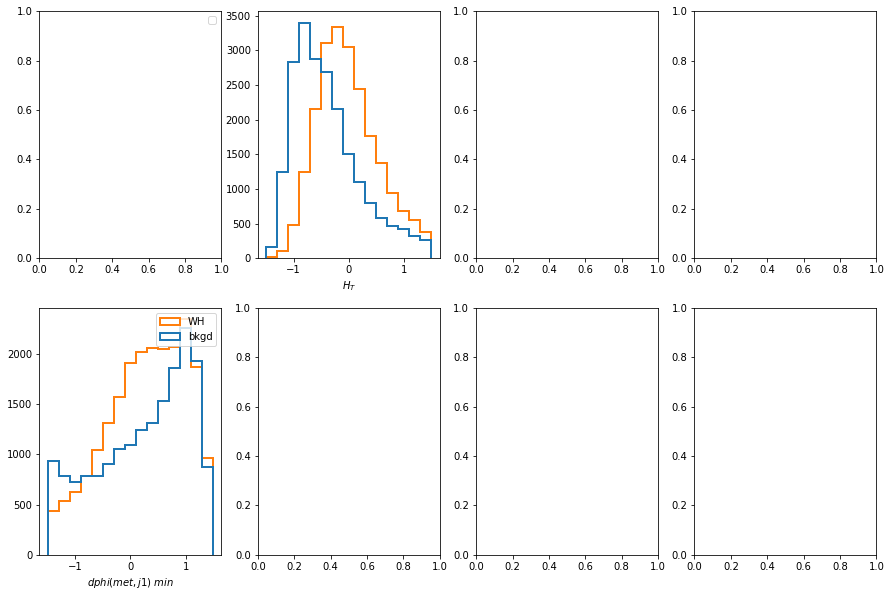

In [6]:
X_bkg = X_train[y_train==0]
X_sig = X_train[y_train==1]

fig, axs = plt.subplots(2,4, figsize=(15,10))

binning = [-1.5,-1.3,-1.1,-0.9,-0.7,-0.5,-0.3,-0.1,0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]

#hist, bins, ax = axs[0,0].hist( [ X_bkg[['met']].values.flatten(), X_sig[['met']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd', 'WH']) 
hist, bins, ax = axs[0,1].hist( [ X_bkg[['ht']].values.flatten(), X_sig[['ht']].values.flatten() ], binning, histtype='step', linewidth=2) 
#hist, bins, ax = axs[0,2].hist( [ X_bkg[['lead_jet_pt']].values.flatten(), X_sig[['lead_jet_pt']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[0,3].hist( [ X_bkg[['sublead_jet_pt']].values.flatten(), X_sig[['sublead_jet_pt']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,0].hist( [ X_bkg[['lead_jet_eta']].values.flatten(), X_sig[['lead_jet_eta']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,1].hist( [ X_bkg[['sublead_jet_eta']].values.flatten(), X_sig[['sublead_jet_eta']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,2].hist( [ X_bkg[['njets']].values.flatten(), X_sig[['njets']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd','WH']) 
#hist, bins, ax = axs[1,3].hist( [ X_bkg[['bjets']].values.flatten(), X_sig[['bjets']].values.flatten() ], binning, histtype='step', linewidth=2) 
#hist, bins, ax = axs[1,0].hist( [ X_bkg[['min_dphi_met_j1']].values.flatten(), X_sig[['min_dphi_met_j1']].values.flatten() ], binning, histtype='step', linewidth=2, label=['ttbar', 'WH']) 
hist, bins, ax = axs[1,0].hist( [ X_bkg[['min_dphi_met_j2']].values.flatten(), X_sig[['min_dphi_met_j2']].values.flatten() ], binning, histtype='step', linewidth=2, label=['bkgd', 'WH']) 
#hist, bins, ax = axs[1,2].hist( [ X_bkg[['min_dphi_met_j3']].values.flatten(), X_sig[['min_dphi_met_j3']].values.flatten() ], binning, histtype='step', linewidth=2, label=['ttbar', 'WH']) 
#hist, bins, ax = axs[1,3].hist( [ X_bkg[['min_dphi_met_j4']].values.flatten(), X_sig[['min_dphi_met_j4']].values.flatten() ], binning, histtype='step', linewidth=2, label=['ttbar', 'WH']) 

#axs[0,0].set_xlabel(r'$E_{T}^{miss}$')
axs[0,1].set_xlabel(r'$H_{T}$')
#axs[0,2].set_xlabel(r'$lead jet pt$')
#axs[0,3].set_xlabel(r'$sublead jet pt$')
#axs[1,0].set_xlabel(r'$lead jet eta$')
#axs[1,1].set_xlabel(r'$sublead jet eta$')
#axs[1,2].set_xlabel(r'$N_{jet}$')
#axs[1,3].set_xlabel(r'$N_{b jet}$')
#axs[1,0].set_xlabel(r'$dphi(met,j0)~{min}$')
axs[1,0].set_xlabel(r'$dphi(met,j1)~{min}$')
#axs[1,2].set_xlabel(r'$dphi(met,j2)~{min}$')
#axs[1,3].set_xlabel(r'$dphi(met,j3)~{min}$')

axs[0,0].legend()
axs[1,0].legend()
#axs[2,0].legend()

plt.savefig('plots/training_vars_norm.pdf')

In [27]:
print(X_bkg[['ht']].values.flatten())

[ 0.14967951 -0.66683249  0.1439023  ... -0.26676087  0.27519622
 -1.06380918]


In [28]:
print(X_sig[['ht']].values.flatten())

[-0.15307368 -0.08278432  1.34968805 ... -0.30671989  1.49446212
 -0.41992564]


In [20]:
epochs = 50
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

model.add( tf.keras.layers.Dense(units=10, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dense(units=20, activation='relu', input_dim=X_train.shape[1], ))
model.add( tf.keras.layers.Dropout( rate = 0.1 ) )
model.add( tf.keras.layers.Dense(units=10, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                40        
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [21]:
from ML.lrcurve import KerasLearningCurve

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0, callbacks=[KerasLearningCurve()])


In [22]:
#model.save( 'data/training.h5', include_optimizer=False )
model.save_weights( 'data/training_weights.h5' )
model.save( 'data/training.h5' )

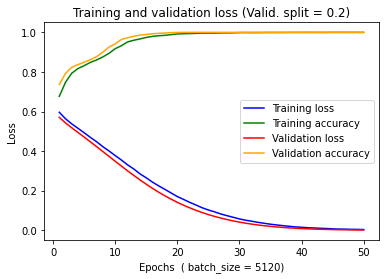

In [23]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)

plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()
plt.savefig('plots/train_validation_loss.pdf')

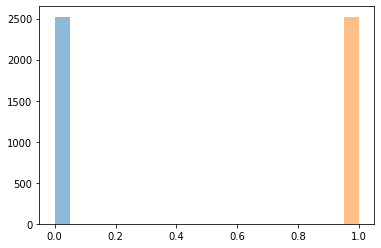

In [24]:
loaded_model = tf.keras.models.load_model('data/training.h5')

# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( loaded_model.predict( X_test.values  ) , index = X_test.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values.flatten(), y_test_pred[y_test==1].values.flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5)
plt.savefig('plots/model_test.pdf')

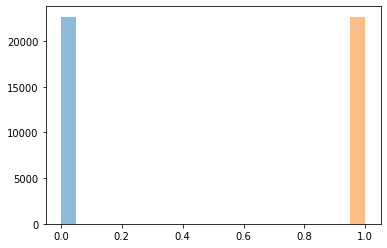

In [25]:
# use the model to predict whether an event is signal or background. this is with the training set
y_train_pred = pd.DataFrame( loaded_model.predict( X_train.values  ) , index = X_train.index)

xbin = 20
hist, bins, ax = plt.hist( [ y_train_pred[y_train==0].values.flatten(), y_train_pred[y_train==1].values.flatten() ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 
plt.savefig('plots/model_train.pdf')

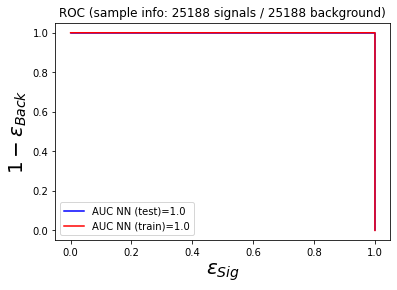

In [26]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN (test)=' + str(round(auc_val_test,4) ))


fpr_train, tpr_train, thresholds_test = roc_curve( y_train, y_train_pred )
auc_val_train = auc(fpr_test, tpr_test)

plt.plot( tpr_train, 1-fpr_train, 'r', label= 'AUC NN (train)=' + str(round(auc_val_train,4) ))


plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')
plt.savefig('plots/roc.pdf')

In [14]:
means = pd.DataFrame(X_mean)
with open('data/means.json', 'w') as f:
    f.write(means.to_json())

# load the data frame and convert it to a series with squeeze
means = pd.read_json('data/means.json').squeeze()

stds = pd.DataFrame(X_std)
with open('data/stds.json', 'w') as f:
    f.write(stds.to_json())

# load the data frame and convert it to a series with squeeze
stds = pd.read_json('data/stds.json').squeeze()

In [15]:
X_train.values

array([[ 0.14967951, -0.45769654, -0.99981254],
       [-0.66683249,  0.51134517, -0.99981254],
       [-0.15307368,  0.83663643,  1.00016544],
       ...,
       [-1.06380918,  0.93533278, -0.99981254],
       [ 1.49446212, -1.67115978,  1.00016544],
       [-0.41992564,  0.99272884,  1.00016544]])

In [16]:
y_train_pred = pd.DataFrame( model.predict( X_train.values  ) , index = X_train.index)

In [17]:
model_l = tf.keras.models.load_model('data/training.h5')
model.predict( X_train.values  )

array([[0.04443423],
       [0.0336169 ],
       [0.7459269 ],
       ...,
       [0.02813522],
       [0.72730136],
       [0.7404833 ]], dtype=float32)

In [18]:
import pickle
#with  as f:
pickle.dump(X_train, open('test.pkl', "wb"))

In [19]:
pickle.load(open('test.pkl', 'rb'))

,ht,min_dphi_met_j2,signal
1055483,0.149680,-0.457697,-0.999813
16658,-0.666832,0.511345,-0.999813
1257046,-0.153074,0.836636,1.000165
1230716,-0.082784,-1.180643,1.000165
455078,0.143902,-0.083465,-0.999813
624216,0.769010,-1.324536,-0.999813
1214446,-0.804935,1.123843,-0.999813
46185,-1.323233,1.013295,-0.999813
408120,-0.881346,-0.869853,-0.999813
1251707,1.349688,-0.626268,1.000165
